In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.io as sio # For importing .mat data files (Matlab source)
import matplotlib.pyplot as plt # For plotting graphs

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Load dataset
## Reference dataset (for training)

In [2]:
reference_dataset = sio.loadmat('./anomalyData.mat')
X = reference_dataset['X']
Xval = reference_dataset['Xval']
yval = reference_dataset['yval']

In [3]:
print("Training dataset shape:      ", X.shape)
print("Validation dataset shape:    ", Xval.shape)
print("Validation data labels shape:", yval.shape)

Training dataset shape:       (307, 2)
Validation dataset shape:     (307, 2)
Validation data labels shape: (307, 1)


# Definition of functions

In [4]:
# Estimate the Gaussian distribution for a dataset whose points have any number of dimensions
def estimateGaussian(X):
    m = X.shape[0]
    #compute mean of X
    sum_ = np.sum(X,axis=0)
    mu = (sum_/m)
    # compute variance of X
    var = np.var(X,axis=0)
    #print(mu, var)
    return mu,var

# Estimate the Gaussian distribution for a dataset whose points have a single dimension set of points
def multivariateGaussian(X, mu, sigma2):
    k = len(mu)
    sigma2 = np.diag(sigma2)
    X = X - mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma2)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma2) * X,axis=1))
    return p

# Compute Multivariate Gaussian for the training dataset

In [5]:
mu,sigma2 = estimateGaussian(X)
p = multivariateGaussian(X, mu, sigma2)
print("Mean of each column in X=     ", mu)
print("Variance of each column in X= ", sigma2)

Mean of each column in X=      [14.11222578 14.99771051]
Variance of each column in X=  [1.83263141 1.70974533]


## Scatter plot

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

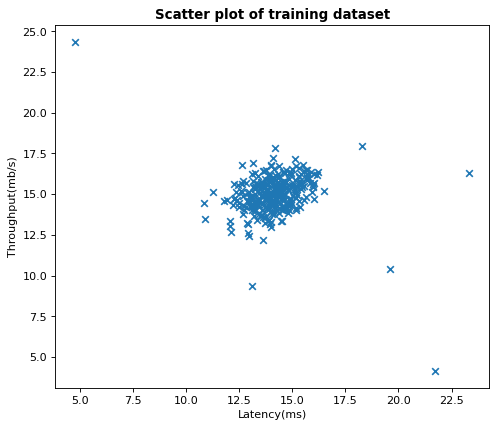

In [7]:
figure(figsize=(7, 6), dpi=80)
plt.scatter(X[:,0],X[:,1],marker="x")
plt.title('Scatter plot of training dataset', fontweight ="bold")
plt.xlabel('Latency(ms)')
plt.ylabel('Throughput(mb/s)')
plt.show()

## Visualization of probabilities

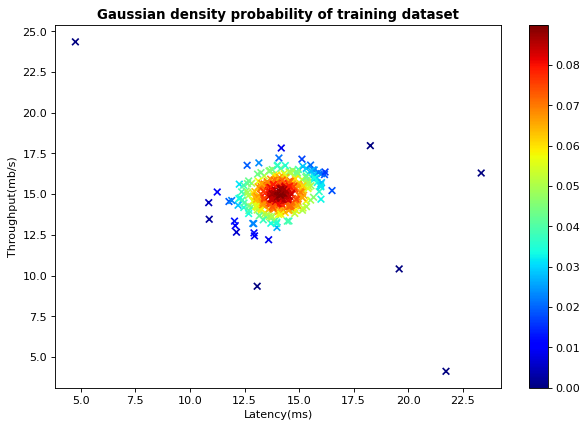

In [8]:
figure(figsize=(9, 6), dpi=80)
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='jet')
plt.colorbar()
plt.title('Gaussian density probability of training dataset', fontweight ="bold")
plt.xlabel('Latency(ms)')
plt.ylabel('Throughput(mb/s)')
plt.show()

# Compute outliers
## Manual selection of threshold probability (=0.02)

In [9]:
epsilon = 0.02 # Look at the graph above for checking this manual selection
outliers = np.nonzero(p < epsilon)[0]
print("Row indexes of outliers:", outliers)

Row indexes of outliers: [  8  19  69  71 109 114 142 145 147 170 199 222 226 241 249 299 300 301
 303 304 305 306]


## Scatter plot encircling anomalies

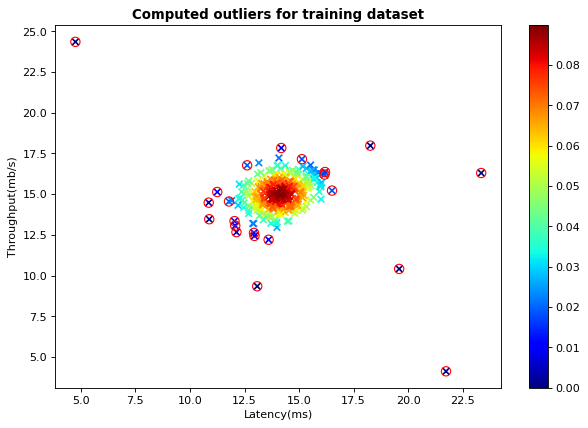

In [10]:
figure(figsize=(9, 6), dpi=80)
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='jet')
plt.colorbar()

# Circling of anomalies
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70)

plt.title('Computed outliers for training dataset', fontweight ="bold")
plt.xlabel('Latency(ms)')
plt.ylabel('Throughput(mb/s)')
plt.show()

# Model evaluation with the validation set

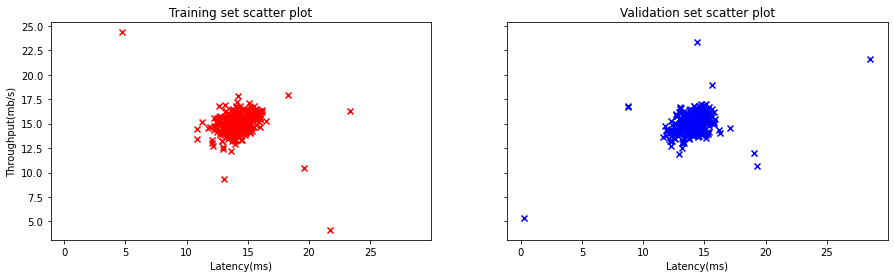

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4), sharex=True, sharey=True)

ax[0].set(title='Training set scatter plot', xlabel='Latency(ms)', ylabel='Throughput(mb/s)')
ax[0].scatter(X[:,0],X[:,1],marker="x", color='red')

ax[1].set(title='Validation set scatter plot', xlabel='Latency(ms)')
ax[1].scatter(Xval[:,0],Xval[:,1],marker="x", color='blue')
plt.show()

In [12]:
# Compare distributions
mu_val,sigma2_val = estimateGaussian(Xval)
print("Mean of each column in X=     ", mu)
print("Mean of each column in Xval=  ", mu_val)
print("Variance of each column in X=    ", sigma2)
print("Variance of each column in Xval= ", sigma2_val)

Mean of each column in X=      [14.11222578 14.99771051]
Mean of each column in Xval=   [14.0192978 15.037747 ]
Variance of each column in X=     [1.83263141 1.70974533]
Variance of each column in Xval=  [2.51787    1.62601673]


In [13]:
# Outliers' indexes in the validation set
outliers_val = np.nonzero(yval == 1)[0]
print("Row indexes of val outliers (actual):", outliers_val)

Row indexes of val outliers (actual): [  9  49 300 301 302 303 304 305 306]


In [14]:
# Compute probabilities in the validation set for the colorbar in the scatter plot
pval = multivariateGaussian(Xval, mu, sigma2)

## Performance of the model

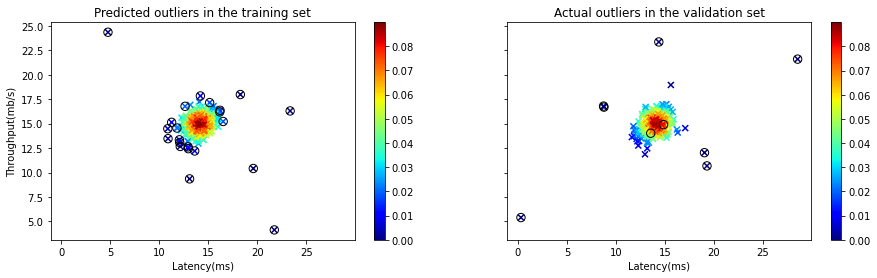

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4), sharex=True, sharey=True)

ax[0].set(title='Predicted outliers in the training set', xlabel='Latency(ms)', ylabel='Throughput(mb/s)')
#ax[0].scatter(X[:,0],X[:,1],marker="x", color='red')
im0 = ax[0].scatter(X[:,0],X[:,1],marker="x",c=p,cmap='jet')
fig.colorbar(im0, ax=ax[0])
ax[0].scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="black",s=70)

ax[1].set(title='Actual outliers in the validation set', xlabel='Latency(ms)')
im1 = ax[1].scatter(Xval[:,0],Xval[:,1],marker="x",c=pval,cmap='jet')
fig.colorbar(im1, ax=ax[1])
ax[1].scatter(Xval[outliers_val,0],Xval[outliers_val,1],marker="o",facecolor="none",edgecolor="black",s=70)

plt.show()

#### Let's compare the prediction in the validation set with its actual values

In [16]:
outliers_val_pred = np.nonzero(yval == 1)[0]
print("Row indexes of outliers:", outliers_val)

outliers_val_pred = np.nonzero(pval < epsilon)[0]
print("Row indexes of val outliers (predicted):", outliers_val_pred)

Row indexes of outliers: [  9  49 300 301 302 303 304 305 306]
Row indexes of val outliers (predicted): [ 13  78 112 127 136 138 168 192 235 246 256 261 283 300 301 302 303 304
 305 306]


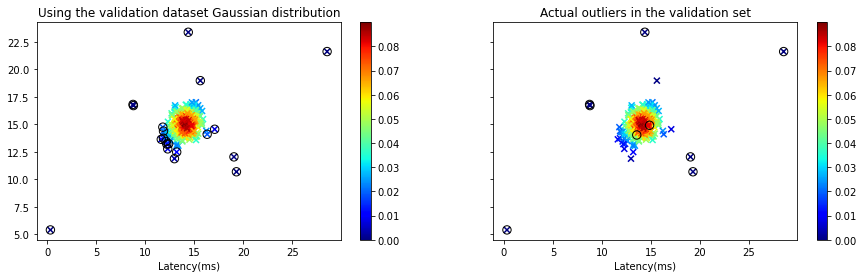

In [17]:
# And now the plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4), sharex=True, sharey=True)

ax[0].set(title='Using the validation dataset Gaussian distribution', xlabel='Latency(ms)')
im0 = ax[0].scatter(Xval[:,0],Xval[:,1],marker="x",c=pval,cmap='jet')
fig.colorbar(im1, ax=ax[0])
ax[0].scatter(Xval[outliers_val_pred,0],Xval[outliers_val_pred,1],marker="o",facecolor="none",edgecolor="black",s=70)

ax[1].set(title='Actual outliers in the validation set', xlabel='Latency(ms)')
im1 = ax[1].scatter(Xval[:,0],Xval[:,1],marker="x",c=pval,cmap='jet')
fig.colorbar(im1, ax=ax[1])
ax[1].scatter(Xval[outliers_val,0],Xval[outliers_val,1],marker="o",facecolor="none",edgecolor="black",s=70)

plt.show()